In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



## Convolutional neural networks

see https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd

see [filter activation demo](http://ml4a.github.io/demos/convolution_all/) [confusion matrix](http://ml4a.github.io/demos/confusion_cifar/)

Tenemos un pequeño dataset de imágenes basado en [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

- cada imagen es de **32x32x3**.
- las imágenes se **linearizan** para la red que ensamblamos con Keras, compuesta por capas tradicionales (**Dense**).
- en ejemplos más sofisticados usaríamos **capas convolucionales** que explotan las correlaciones 2D propias de las imágenes.

In [10]:
!wget -c https://s3.amazonaws.com/rlx/mini_cifar.h5

--2018-10-08 08:52:46--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.81.195
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.81.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [11]:
def show_image_mosaic(imgs, labels, figsize=(12, 12), idxs=None):

    plt.figure(figsize=figsize)
    for labi,lab in [i for i in enumerate(np.unique(labels))]:
        k = imgs[labels == lab]
        _idxs = idxs[:10] if idxs is not None else np.random.permutation(len(k))[:10]
        for i, idx in enumerate(_idxs):
            if i == 0:
                plt.subplot(10, 11, labi*11+1)
                plt.title("LABEL %d" % lab)
                plt.plot(0, 0)
                plt.axis("off")

            img = k[idx]
            plt.subplot(10, 11, labi*11+i+2)
            plt.imshow(img, cmap=plt.cm.Greys_r)
            plt.axis("off")

In [12]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

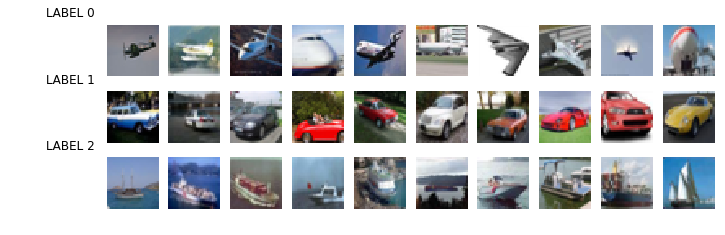

In [13]:
show_image_mosaic(x_cifar, y_cifar)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    759
0    756
1    738
dtype: int64

distribution of test classes
2    266
0    249
1    236
dtype: int64


construimos el modelo con Keras

In [16]:
num_classes = len(np.unique(y_cifar))


In [17]:
def get_model(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Flatten(name="flatten")(inputs)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu, name="dense_1")(layers)
    layers = tf.keras.layers.Dropout(0.2, name="dropout")(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [18]:
num_classes = len(np.unique(y_cifar))
model = get_model(num_classes)

using 3 classes


observa los pesos inicializados y sus tamaños

In [19]:
weights = model.get_weights()
for i in weights:
    print i.shape

(3072, 16)
(16,)
(16, 3)
(3,)


In [20]:
weights[2]

array([[ 0.32746035,  0.4620523 , -0.37140435],
       [-0.48592135, -0.31895322, -0.49444044],
       [ 0.12182581,  0.15643358, -0.5593335 ],
       [-0.34723473,  0.18187726, -0.25250706],
       [-0.1259934 , -0.17987186, -0.0019356 ],
       [-0.28973413, -0.16604555,  0.42130244],
       [ 0.43896908,  0.23293573, -0.5234142 ],
       [ 0.19503045, -0.1370269 ,  0.56004876],
       [-0.21765962, -0.20602724,  0.24168068],
       [ 0.5397391 , -0.49079272,  0.3643908 ],
       [-0.07900137, -0.5206981 , -0.29931822],
       [-0.3658189 , -0.23163208, -0.37477022],
       [ 0.12128645, -0.44437748,  0.11436212],
       [-0.34089532,  0.19944358, -0.44802856],
       [-0.15671507,  0.45562404, -0.4929092 ],
       [ 0.45871383,  0.12541813,  0.17078817]], dtype=float32)

In [21]:
num_classes = len(np.unique(y_cifar))

model = get_model(num_classes)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
model.reset_states()
model.fit(x_train, y_train, epochs=5, callbacks=[tensorboard],steps_per_epoch=10)
model.evaluate(x_test, y_test)

using 3 classes
Epoch 1/5
10/10 [==============================] - 2s 158ms/step - loss: 1.3965 - acc: 0.3495
Epoch 2/5
10/10 [==============================] - 1s 65ms/step - loss: 1.0675 - acc: 0.3966
Epoch 3/5
10/10 [==============================] - 1s 57ms/step - loss: 1.0401 - acc: 0.3568
Epoch 4/5
10/10 [==============================] - 1s 63ms/step - loss: 0.9968 - acc: 0.4486
Epoch 5/5
751/751 [==============================] - 0s 223us/step


[0.9723360521021918, 0.5592543281188183]

## preprocesado de imágenes

realizamos ahora una transformación sencilla sobre las imágenes usando las herramientas de TF

In [22]:
timgs = tf.placeholder(dtype=tf.float32, shape=(None, 32,32,3))
cimgs = tf.image.adjust_contrast(timgs, 10.)

with tf.Session() as sess:
    cx_train = sess.run(cimgs, feed_dict={timgs: x_train})
    cx_test  = sess.run(cimgs, feed_dict={timgs: x_test})

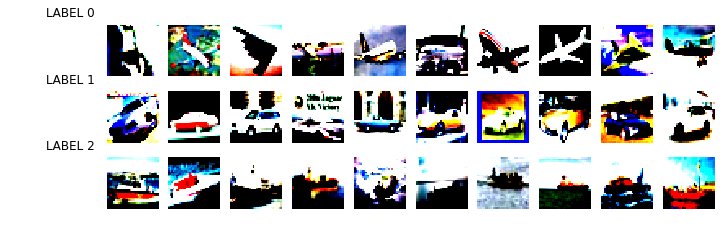

In [23]:
show_image_mosaic(cx_train, y_train)

fíjate cómo mejora la predicción

In [24]:
model = get_model(num_classes)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
model.fit(cx_train, y_train, epochs=5, callbacks=[tensorboard], steps_per_epoch=10)
model.evaluate(cx_test, y_test)

using 3 classes
Epoch 1/5
10/10 [==============================] - 1s 92ms/step - loss: 1.5500 - acc: 0.4570
Epoch 2/5
10/10 [==============================] - 0s 49ms/step - loss: 1.0256 - acc: 0.5270
Epoch 3/5
10/10 [==============================] - 0s 45ms/step - loss: 0.8952 - acc: 0.5708
Epoch 4/5
10/10 [==============================] - 0s 46ms/step - loss: 0.8064 - acc: 0.6140
Epoch 5/5
751/751 [==============================] - 0s 205us/step


[1.0235105941838494, 0.585885486415477]

## Input pipelines

pero hemos hecho toda la **transformación en memoria**, y nos gustaría implementarla como un input pipeline. Previendo esto, la transformación ya la habíamos hecho en tensorflow, por tanto podemos **integrar** el grafo computacional de la misma el grafo del modelo.

In [27]:
def get_dataset(imgs, labels, repeat, batch_size, shuffle=True):
    d1 = tf.data.Dataset.from_tensor_slices((tf.constant(imgs, dtype=tf.float32), 
                                             tf.constant(labels.reshape(-1,1), dtype=tf.float32)))

    resize    = lambda x,y: (tf.image.resize_images(x,(30,30)), y)
    transform = lambda x,y: ({"input_1": tf.image.adjust_contrast(x, 10.)},{"output_1": y})
    if shuffle:
        d1 = d1.shuffle(buffer_size=200)
    d1 = d1.map(resize)
    d1 = d1.map(transform)
    
    d1 = d1.repeat(repeat)
    d1 = d1.batch(batch_size)    
    return d1

observa que hay cierta superposición entre las nociones de batch_size, steps, epochs, repeats en keras y en el dataset API.

en realidad, keras considera cada batch que le venga de un dataset como un step. p.ej: con

- **2200 elementos** en total
- **dataset repeat=2**
- **dataset batch_size=10**

el dataset suministra un total de 2200/10*2 = 440 batches 

si en keras `fit` usamos 5 epochs de 100 `steps_per_epoch` cada uno, nos quedaremos sin datos durante el quinto epoch. A no ser qué:

- el **dataset repeat** sea -1, o lo aumentemos suficientemente
- reduzcamos el batch_size para que produzcan más batches más pequeños
- reduzcamos el número de `steps_per_epoch



In [28]:
batch_size = 20

model = get_model(num_classes, img_size=30)
train_dataset = get_dataset(x_train, y_train, repeat=-1, batch_size=100)
model.fit(train_dataset, epochs=5, steps_per_epoch=100)


using 3 classes
Epoch 1/5
100/100 [==============================] - 2s 17ms/step - loss: 1.0077 - acc: 0.5537
Epoch 2/5
100/100 [==============================] - 1s 11ms/step - loss: 0.7103 - acc: 0.6698
Epoch 3/5
100/100 [==============================] - 1s 11ms/step - loss: 0.5940 - acc: 0.7321
Epoch 4/5
100/100 [==============================] - 1s 11ms/step - loss: 0.5501 - acc: 0.7545
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.4788 - acc: 0.7918


y de forma análoga para la evaluación

In [29]:
eval_dataset = get_dataset(x_test, y_test, repeat=1, batch_size=5)
model.evaluate(eval_dataset, steps=100)

100/100 [==============================] - 0s 3ms/step


[1.0922163592278957, 0.6240000140666961]

otra alternativa sería usar [`tf.keras.estimator.model_to_estimator`](https://www.tensorflow.org/api_docs/python/tf/keras/estimator/model_to_estimator), que convierte un modelo Keras para ser usado como cualquier otro estimador TF.

## Imágenes desde ficheros

ref https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### descargamos imágenes de dos queries en google

In [30]:
!pip install google_images_download

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [79]:
downloads = "/tmp/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [80]:
!rm -rf $downloads
!mkdir $downloads

In [81]:
cfg="""
{
    "Records": [
        {
            "keywords": "dog",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "snake",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [82]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [83]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = dog
Evaluating...
Starting Download...
Completed Image ====> 1. common-dog-behaviors-explained.jpg
Completed Image ====> 2. http%3a%2f%2fcdn.cnn.com%2fcnnnext%2fdam%2fassets%2f180316113418-travel-with-a-dog-3.jpg
Completed Image ====> 3. file-20180212-58348-7huv6f.jpeg
Completed Image ====> 4. scroll001.jpg
Completed Image ====> 5. ol9ceoqxidudap8owlwn.jpg
Completed Image ====> 6. girl-names-1024x563.jpg
Completed Image ====> 7. entlebucher-mountain-dog-on-white-01.jpg
Completed Image ====> 8. natural-dog-law-2-to-dogs%2c-energy-is-everything.jpg
Completed Image ====> 9. alex_cearns_tiny_dog.jpg
Completed Image ====> 10. 180516-woman-mauled-by-angry-wiener-dogs-feature.jpg
Completed Image ====> 11. puppy-dog.jpg
Completed Image ====> 12. small-dog-breeds.jpg
Completed Image ====> 13. latest?cb=20180619214353.jpg
Completed Image ====> 14. 21398477-eed6-4acc-8bf0-f67272a94235-best-toothpaste-for-dogs-hero.jpg
Completed Image ====> 15. merlin_140144286_193276f

### revisamos las imágenes y eliminamos las defectuosas

In [84]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print ".",
        try:
            io.imread(fname)
        except:
            print "\nremoving",fname,"as cannot be read\n"
            !rm '$fname'

. . . . . . 
removing /tmp/downloads/dog/33. telemmglpict000144075850_trans_nvbqzqnjv4bqtbzsuvge3rsjxi0sxulx8gykxipqmhbxbjfymkqynkk.jpeg as cannot be read

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/snake/29. burmese-pythons.jpg as cannot be read

. . . . . . . . . . . 
removing /tmp/downloads/snake/47. ?media_id=1442783652664868.jpg as cannot be read

. . . .


### organizamos las imágenes en train y en test

In [85]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print classdirs

['dog', 'snake']


In [86]:
!rm -rf $traintest_imgs

In [87]:
for classdir in classdirs:
    print classdir
    print "    splitting files ... ",
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print "copying files"
    for f in files_train:
        !cp '$f' $traintest_imgs/train/$classdir
    for f in files_test:
        !cp '$f' $traintest_imgs/test/$classdir

dog
    splitting files ...  copying files
snake
    splitting files ...  copying files


### sanity check 1

In [88]:
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files), "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files), "test images"

dog
       34 train images
       15 test images
snake
       33 train images
       15 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [90]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 65 images belonging to 2 classes.


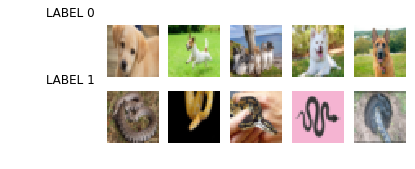

In [92]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
        
show_image_mosaic(imgs, labels)

### train keras!!!

In [93]:
num_classes = len(classdirs)
model = get_model(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Found 65 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 19s 190ms/step - loss: 0.7432 - acc: 0.6120 - val_loss: 0.8100 - val_acc: 0.5866
Epoch 2/5
100/100 [==============================] - 17s 172ms/step - loss: 0.5124 - acc: 0.7320 - val_loss: 0.6458 - val_acc: 0.5530
Epoch 3/5
100/100 [==============================] - 19s 191ms/step - loss: 0.4033 - acc: 0.7910 - val_loss: 0.6476 - val_acc: 0.6253
Epoch 4/5
100/100 [==============================] - 18s 181ms/step - loss: 0.3089 - acc: 0.8500 - val_loss: 0.5319 - val_acc: 0.7235
Epoch 5/5
100/100 [==============================] - 18s 179ms/step - loss: 0.2487 - acc: 0.8350 - val_loss: 0.5656 - val_acc: 0.6899


### predictions

In [94]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 29 images belonging to 2 classes.


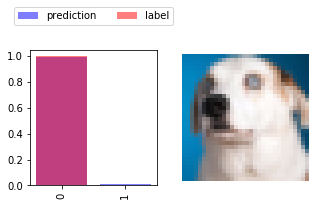

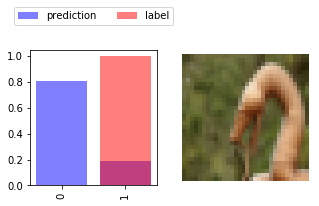

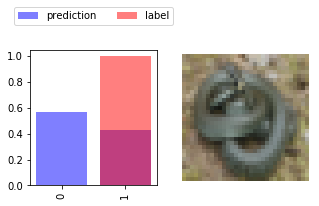

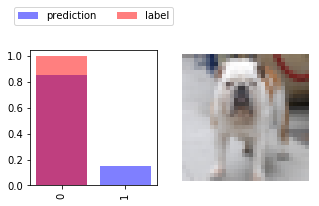

In [96]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
show_preds(x, preds)

con los input pipielines del dataset API podemos consumir directamente imágenes desde ficheros también: [Decoding Image Data and Resizing it](https://www.tensorflow.org/guide/datasets#decoding_image_data_and_resizing_it)

## Capas convolucionales

seguramente la siguiente red te funcione mejor con imágenes más grandes y con más imágenes!!!

experimenta con [esta interacción](http://ml4a.github.io/demos/convolution_all/) para construirte la intuición de la convolución

fíjate que:

- la capa convolucional acepta directamente las imágenes (no hay `Flatten`)
- detrás de la capa convolucional creamos una red clásica como la anterior (**fully connected**)

In [97]:
def get_conv_model(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [98]:
model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

Found 65 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 19s 189ms/step - loss: 0.2358 - acc: 0.8780 - val_loss: 0.7037 - val_acc: 0.5866
Epoch 2/5
100/100 [==============================] - 18s 178ms/step - loss: 0.1766 - acc: 0.9110 - val_loss: 0.5925 - val_acc: 0.7287
Epoch 3/5
100/100 [==============================] - 18s 175ms/step - loss: 0.1672 - acc: 0.9290 - val_loss: 0.7484 - val_acc: 0.7261
Epoch 4/5
100/100 [==============================] - 19s 186ms/step - loss: 0.1568 - acc: 0.9240 - val_loss: 0.6898 - val_acc: 0.7287
Epoch 5/5
100/100 [==============================] - 17s 168ms/step - loss: 0.1372 - acc: 0.9340 - val_loss: 0.7948 - val_acc: 0.7209


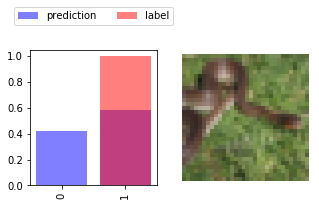

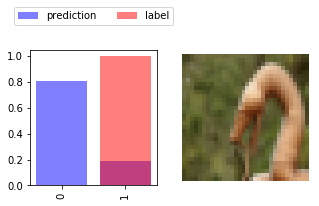

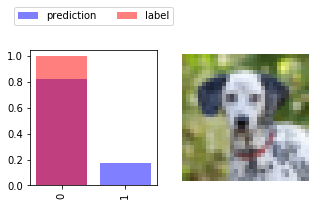

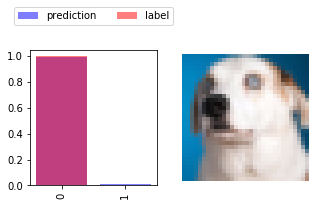

In [105]:
show_preds(x, preds)